In [1]:
import torch
import gymnasium
import sys
import tqdm
import numpy as np
import os
rocket_dir = os.path.split(os.path.abspath(os.curdir))[:-1]
rocket_src_dir = os.path.join(*rocket_dir, 'src')
rocket_dir = os.path.join(*rocket_dir)

print(f'Appending to sys.path:', [rocket_dir, rocket_src_dir])

sys.path.append(rocket_dir)
sys.path.append(rocket_src_dir)

from src.environments.frozen_env import FrozenActions, make_frozen_env
from src.agents.LLaMa2_agent import LLaMaAgent

pygame 2.5.2 (SDL 2.28.2, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
Appending to sys.path: ['/mnt/llmdata/home/gbonetta/progetti/rocket', '/mnt/llmdata/home/gbonetta/progetti/rocket/src']


/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment FrozenLakeText-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Hanoi3Disk-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: U

In [2]:
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

In [3]:
LOCAL_NUM_ENVS = 1
SEED = 1234

In [4]:
is_crafter = False 
from src.environments.minigrid_env import make_minigrid_env
runs_directory = 'runs_directory_prova'
envs = gymnasium.vector.SyncVectorEnv(
            [make_minigrid_env(
                runs_directory,
                'MiniGrid-DoorKey-5x5-v0', #'MiniGrid-Fetch-8x8-N3-v0',#'MiniGrid-DoorKey-5x5-v0', #'MiniGrid-LockedRoom-v0','MiniGrid-LavaGapS7-v0', 'MiniGrid-PutNear-8x8-N3-v0', #'MiniGrid-PutNear-8x8-N3-v0','MiniGrid-BlockedUnlockPickup-v0', 'MiniGrid-LavaCrossingS11N5-v0', 'MiniGrid-DoorKey-8x8-v0' 'MiniGrid-SimpleCrossingS11N5-v0' 'MiniGrid-LavaCrossingS9N3-v0' 'MiniGrid-SimpleCrossingS11N5-v0'
                possible_actions_list=['left','right','forward','pickup','toggle'],  #left right forward pickup toggle
                fov=1,
                fixed_orientation=False,
                seed=1 + i *100,
                save_video=False,
                save_video_every=100,
                save_stats=False
            )
            for i in range(1)
            ])

In [5]:
observation_space = envs.single_observation_space
action_enum = envs.envs[0].action_enum

In [6]:
agent = LLaMaAgent('meta-llama/Llama-2-7b-chat-hf',
                        action_enum=action_enum,
                         is_lora=True, 
                         padding_side="right", 
                         gradient_ckpt=False,
                         disable_adapters_for_generation=True)
agent.critic.to('cuda')

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


trainable params: 33,554,432 || all params: 6,771,970,048 || trainable%: 0.49548996469513035


Sequential(
  (0): Linear(in_features=4096, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
)

In [7]:
agent.network.eval()
agent.critic.eval()

Sequential(
  (0): Linear(in_features=4096, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
)

In [10]:
TEMPERATURE = 0.3
value_prompt_template= "You are an agent in a 2D game. {} What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls."
action_template= "Based on the information provided, the best move would be to {}"

/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/minigrid/wrappers.py:62: UserWarning: WARN: A seed has been passed to `ReseedWrapper.reset` which is ignored.
  logger.warn(
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


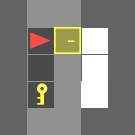



STEP 0:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- a yellow key 2 steps to your right.\n- the goal 4 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- a yellow key 2 steps to your right.\n- the goal 4 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn rig

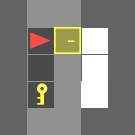



STEP 1:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- a yellow key 2 steps to your right.\n- the goal 4 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- a yellow key 2 steps to your right.\n- the goal 4 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn rig

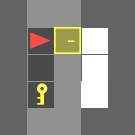



STEP 2:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- a yellow key 2 steps to your right.\n- the goal 4 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- a yellow key 2 steps to your right.\n- the goal 4 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn rig

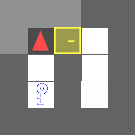



STEP 3:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- a yellow key 2 steps behind you.\n- the goal 4 steps behind you.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- a yellow key 2 steps behind you.\n- the goal 4 steps behind you.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Re

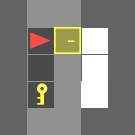



STEP 4:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- a yellow key 2 steps to your right.\n- the goal 4 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- a yellow key 2 steps to your right.\n- the goal 4 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn rig

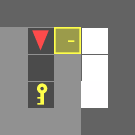



STEP 5:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step behind you.\n- a grey wall 1 step to your right.\n- a locked yellow door 1 step to your left.\n- a yellow key 2 steps in front of you.\n- the goal 4 steps in front of you to the left.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step behind you.\n- a grey wall 1 step to your right.\n- a locked yellow door 1 step to your left.\n- a yellow key 2 steps in front of you.\n- the goal 4 steps in front of you to the left.\n What's the next best action? Choose exactly one from [turn left, turn right

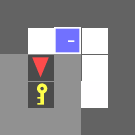



STEP 6:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- a yellow key 1 step in front of you.\n- the goal 3 steps in front of you to the left.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- a yellow key 1 step in front of you.\n- the goal 3 steps in front of you to the left.\n What's the next best action? Choose exactly one from [turn left, turn right

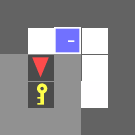



STEP 7:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- a yellow key 1 step in front of you.\n- the goal 3 steps in front of you to the left.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- a yellow key 1 step in front of you.\n- the goal 3 steps in front of you to the left.\n What's the next best action? Choose exactly one from [turn left, turn right

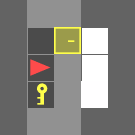



STEP 8:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- a yellow key 1 step to your right.\n- the goal 3 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- a yellow key 1 step to your right.\n- the goal 3 steps in front of you to the right.\n What's the next best action? Choose exactly

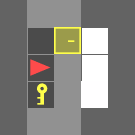



STEP 9:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- a yellow key 1 step to your right.\n- the goal 3 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- a yellow key 1 step to your right.\n- the goal 3 steps in front of you to the right.\n What's the next best action? Choose exactly

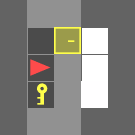



STEP 10:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- a yellow key 1 step to your right.\n- the goal 3 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- a yellow key 1 step to your right.\n- the goal 3 steps in front of you to the right.\n What's the next best action? Choose exactl

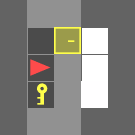



STEP 11:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- a yellow key 1 step to your right.\n- the goal 3 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- a yellow key 1 step to your right.\n- the goal 3 steps in front of you to the right.\n What's the next best action? Choose exactl

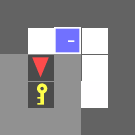



STEP 12:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- a yellow key 1 step in front of you.\n- the goal 3 steps in front of you to the left.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- a yellow key 1 step in front of you.\n- the goal 3 steps in front of you to the left.\n What's the next best action? Choose exactly one from [turn left, turn righ

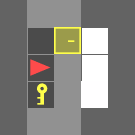



STEP 13:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- a yellow key 1 step to your right.\n- the goal 3 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- a yellow key 1 step to your right.\n- the goal 3 steps in front of you to the right.\n What's the next best action? Choose exactl

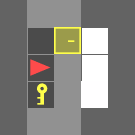



STEP 14:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- a yellow key 1 step to your right.\n- the goal 3 steps in front of you to the right.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- a yellow key 1 step to your right.\n- the goal 3 steps in front of you to the right.\n What's the next best action? Choose exactl

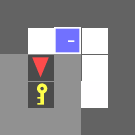



STEP 15:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- a yellow key 1 step in front of you.\n- the goal 3 steps in front of you to the left.\n What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- a yellow key 1 step in front of you.\n- the goal 3 steps in front of you to the left.\n What's the next best action? Choose exactly one from [turn left, turn righ

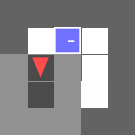



STEP 16:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- the goal 3 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- the goal 3 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, 

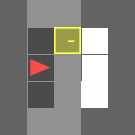



STEP 17:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn lef

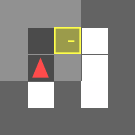



STEP 18:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the right.\n- a grey wall 1 step to your left.\n- a grey wall 1 step to your right.\n- the goal 3 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the right.\n- a grey wall 1 step to your left.\n- a grey wall 1 step to your right.\n- the goal 3 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up

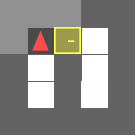



STEP 19:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you

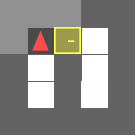



STEP 20:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you

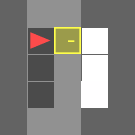



STEP 21:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick 

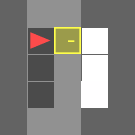



STEP 22:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick 

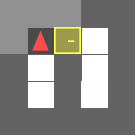



STEP 23:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you

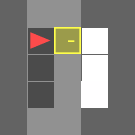



STEP 24:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick 

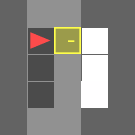



STEP 25:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick 

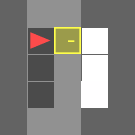



STEP 26:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick 

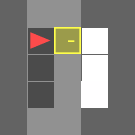



STEP 27:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick 

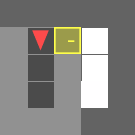



STEP 28:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step behind you.\n- a grey wall 1 step to your right.\n- a locked yellow door 1 step to your left.\n- the goal 4 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step behind you.\n- a grey wall 1 step to your right.\n- a locked yellow door 1 step to your left.\n- the goal 4 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, to

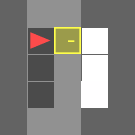



STEP 29:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick 

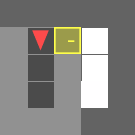



STEP 30:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step behind you.\n- a grey wall 1 step to your right.\n- a locked yellow door 1 step to your left.\n- the goal 4 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step behind you.\n- a grey wall 1 step to your right.\n- a locked yellow door 1 step to your left.\n- the goal 4 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, to

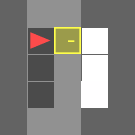



STEP 31:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick 

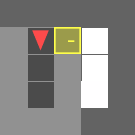



STEP 32:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step behind you.\n- a grey wall 1 step to your right.\n- a locked yellow door 1 step to your left.\n- the goal 4 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step behind you.\n- a grey wall 1 step to your right.\n- a locked yellow door 1 step to your left.\n- the goal 4 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, to

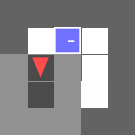



STEP 33:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- the goal 3 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- the goal 3 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, 

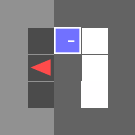



STEP 34:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step in front of you.\n- a grey wall 1 step behind you.\n- the goal 3 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step in front of you.\n- a grey wall 1 step behind you.\n- the goal 3 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot 

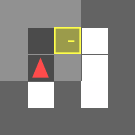



STEP 35:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the right.\n- a grey wall 1 step to your left.\n- a grey wall 1 step to your right.\n- the goal 3 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the right.\n- a grey wall 1 step to your left.\n- a grey wall 1 step to your right.\n- the goal 3 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up

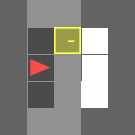



STEP 36:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn lef

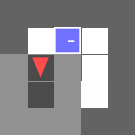



STEP 37:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- the goal 3 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- the goal 3 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, 

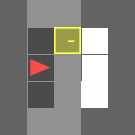



STEP 38:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn lef

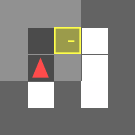



STEP 39:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the right.\n- a grey wall 1 step to your left.\n- a grey wall 1 step to your right.\n- the goal 3 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the right.\n- a grey wall 1 step to your left.\n- a grey wall 1 step to your right.\n- the goal 3 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up

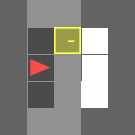



STEP 40:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn lef

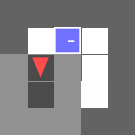



STEP 41:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- the goal 3 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- the goal 3 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, 

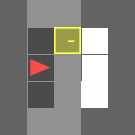



STEP 42:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn lef

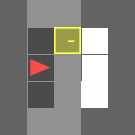



STEP 43:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn lef

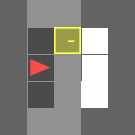



STEP 44:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 3 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn lef

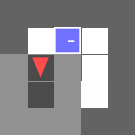



STEP 45:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- the goal 3 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- the goal 3 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, 

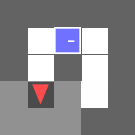



STEP 46:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- the goal 2 steps to your left.\n- a grey wall 1 step in front of you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps behind you.\n- a grey wall 1 step to your right.\n- a grey wall 1 step to your left.\n- the goal 2 steps to your left.\n- a grey wall 1 step in front of you.\n and you carry a yellow key. What's the next best action? Choose exactly one fr

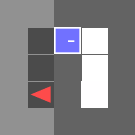



STEP 47:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps behind you.\n- a grey wall 1 step in front of you.\n- a grey wall 1 step behind you.\n- the goal 2 steps behind you.\n- a grey wall 1 step to your left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps behind you.\n- a grey wall 1 step in front of you.\n- a grey wall 1 step behind you.\n- the goal 2 steps behind you.\n- a grey wall 1 step to your left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn l

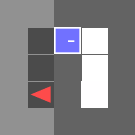



STEP 48:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps behind you.\n- a grey wall 1 step in front of you.\n- a grey wall 1 step behind you.\n- the goal 2 steps behind you.\n- a grey wall 1 step to your left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps behind you.\n- a grey wall 1 step in front of you.\n- a grey wall 1 step behind you.\n- the goal 2 steps behind you.\n- a grey wall 1 step to your left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn l

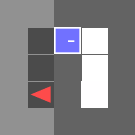



STEP 49:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps behind you.\n- a grey wall 1 step in front of you.\n- a grey wall 1 step behind you.\n- the goal 2 steps behind you.\n- a grey wall 1 step to your left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps behind you.\n- a grey wall 1 step in front of you.\n- a grey wall 1 step behind you.\n- the goal 2 steps behind you.\n- a grey wall 1 step to your left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn l

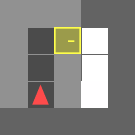



STEP 50:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps in front of you to the right.\n- a grey wall 1 step to your left.\n- a grey wall 1 step to your right.\n- the goal 2 steps to your right.\n- a grey wall 1 step behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps in front of you to the right.\n- a grey wall 1 step to your left.\n- a grey wall 1 step to your right.\n- the goal 2 steps to your right.\n- a grey wall 1 step behind you.\n and you carry a yellow key. What's the next best a

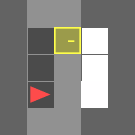



STEP 51:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 2 steps in front of you.\n- a grey wall 1 step to your right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps in front of you to the left.\n- a grey wall 1 step behind you.\n- a grey wall 1 step in front of you.\n- the goal 2 steps in front of you.\n- a grey wall 1 step to your right.\n and you carry a yellow key. What's the nex

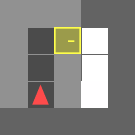



STEP 52:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps in front of you to the right.\n- a grey wall 1 step to your left.\n- a grey wall 1 step to your right.\n- the goal 2 steps to your right.\n- a grey wall 1 step behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps in front of you to the right.\n- a grey wall 1 step to your left.\n- a grey wall 1 step to your right.\n- the goal 2 steps to your right.\n- a grey wall 1 step behind you.\n and you carry a yellow key. What's the next best a

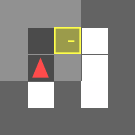



STEP 53:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the right.\n- a grey wall 1 step to your left.\n- a grey wall 1 step to your right.\n- the goal 3 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 2 steps in front of you to the right.\n- a grey wall 1 step to your left.\n- a grey wall 1 step to your right.\n- the goal 3 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up

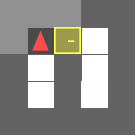



STEP 54:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you

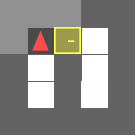



STEP 55:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you

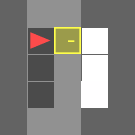



STEP 56:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a grey wall 1 step behind you.\n- a locked yellow door 1 step in front of you.\n- the goal 4 steps in front of you to the right.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick 

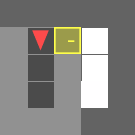



STEP 57:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step behind you.\n- a grey wall 1 step to your right.\n- a locked yellow door 1 step to your left.\n- the goal 4 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step behind you.\n- a grey wall 1 step to your right.\n- a locked yellow door 1 step to your left.\n- the goal 4 steps in front of you to the left.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, to

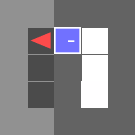



STEP 58:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your right.\n- a grey wall 1 step in front of you.\n- a locked yellow door 1 step behind you.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your right.\n- a grey wall 1 step in front of you.\n- a locked yellow door 1 step behind you.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you can

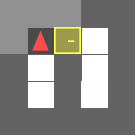



STEP 59:
prompts - ["<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you cannot go across walls. [/INST] Based on the information provided, the best move would be to turn left", "<s>[INST] You are an agent in a 2D game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step in front of you.\n- a grey wall 1 step to your left.\n- a locked yellow door 1 step to your right.\n- the goal 4 steps behind you.\n and you carry a yellow key. What's the next best action? Choose exactly one from [turn left, turn right, go forward, pick up, toggle]. Remember that you

In [11]:
next_obs, infos = envs.reset(seed=SEED)
next_obs = torch.Tensor(next_obs).to('cuda')
next_text_obs = infos.get('obs', [None]*LOCAL_NUM_ENVS)

for step in range(60):
    with torch.no_grad():
        res = agent.get_action_and_value(next_obs, text_description=next_text_obs)
        res = agent.get_action_and_value(next_obs, 
                                                 value_prompt_template=value_prompt_template,
                                                 action_template=action_template,
                                                 text_description=next_text_obs, 
                                                 temperature=TEMPERATURE, 
                                                 generate_actions=False,
                                                 normalization_by_words=False,
                                                 advanced_action_matching=False)
        action, logprob, value = res['action'], res['log_prob'], res['values']

        to_pil = transforms.ToPILImage()
        pil_image = to_pil(transforms.functional.invert(next_obs[0].permute(2, 0, 1)))
        display(pil_image)

        next_obs, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        next_text_obs = infos.get('obs', [None]*LOCAL_NUM_ENVS)
        
        print(f"\n\nSTEP {step}:\nprompts - {res.get('prompts', 'no prompts')}")
        print(f"\nAction {action}, {res['action_logits']}.\nresulted in:\n{next_obs.shape=}, {reward=}, {terminations=}, {truncations=}, \n{next_text_obs=}\n")     

        next_obs = torch.Tensor(next_obs).to('cuda')

In [ ]:

message = "Instruct: You are an agent in a survival 2D game. the agent sees:\na wall north of him, normal ground south of him, a wall west of him, a deadly trap east of him. The goal is south east of him. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]"
conversation = [{"role": "user", "content": message}]
input_ids = tokenizer.apply_chat_template(conversation, tokenize=False)
context_prompt = agent.tokenizer(input_ids, return_tensors="pt", padding=True)
result = agent.network.generate(**context_prompt, max_new_tokens=200)
print(tokenizer.batch_decode(result))

In [ ]:
print(f"{len(observations_dataset)}")
for k,v in observations_dataset.items():
    #print(f"prompt: {k}\n")
    message = k
    context_prompt = agent.tokenizer(message, return_tensors="pt", padding=True)
    result = agent.network.generate(**context_prompt, max_new_tokens=200)
    print(f"generation: {agent.tokenizer.batch_decode(result)[0]}\n")

In [ ]:
print(k[:-8] + " Be brief on your choice explanation.")